In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce, lru_cache, partial
from importlib import reload
from typing import Iterable, Dict, Tuple
import datetime as dt
import copy
import tqdm.auto as tqdm

np.set_printoptions(precision=3)
pd.set_option("display.precision", 3)
%matplotlib inline
sns.set_style('darkgrid')
sns.set_theme(rc={'figure.figsize':(8, 6)})

In [2]:
from loader import load_history

In [3]:
YEARDAYS = 250

In [4]:
def calc_return(price, n_days=YEARDAYS):
    log_price = np.log(price)
    total_ret = log_price.iloc[-1] - log_price.iloc[0]
    _log_ret = n_days * total_ret / (len(price) - 1)
    _ret = np.exp(_log_ret) - 1
    return _ret
def calc_volatility(price, n_days=YEARDAYS):
    log_price = np.log(price)
    log_ret = log_price - log_price.shift(1)
    log_ret_std = log_ret.std() * np.sqrt(n_days)
    volatility = np.exp(log_ret_std) - 1
    return volatility

In [5]:
def calc_mdd(price: pd.DataFrame) -> pd.DataFrame:
    drawdown = 1 - price / price.cummax()
    return drawdown
def calc_low5_mdd(price: pd.DataFrame):
    _mdd = calc_mdd(price)
    _mdd_low10 = _mdd.quantile(0.95)
    return _mdd_low10

In [6]:
def calc_df_risk_return(price_df: pd.DataFrame, ret_fn=calc_return, risk_fn=calc_volatility):
    df_dict = {
        'symbol': [],
        'risk': [],
        'return': [],
    }
    for sym in price_df.columns:
        _df = price_df[sym].dropna()
        ret = ret_fn(_df)
        risk = risk_fn(_df)
        df_dict['symbol'].append(sym)
        df_dict['risk'].append(risk)
        df_dict['return'].append(ret)

    return pd.DataFrame.from_dict(df_dict)

In [7]:
def merge_price_df_two(a, b):
    return pd.concat([a, b], axis=1)
def merge_price_df(dfs: Dict[str, pd.DataFrame], target='adj_hlc3') -> pd.DataFrame:
    renamed = {
        sym: d[target].rename(sym)
        for sym, d in dfs.items()
    }
    return reduce(merge_price_df_two, renamed.values())

In [8]:
def normalize_price(df: pd.DataFrame):
    ret = df.apply(lambda s: s / s.dropna().iloc[0])
    return ret

In [9]:
def calc_rolling_corr(log_price_df: pd.DataFrame, n_days=60):
    log_ret = (log_price_df - log_price_df.shift(1)).iloc[1:]
    rolling_corrs = log_ret.rolling(window=n_days).corr()
    corr_mean = rolling_corrs.groupby(level=1).mean()
    corr_mean = corr_mean.reindex(columns=corr_mean.columns, index=corr_mean.columns)
    return corr_mean

In [10]:

def label_point(data, ax, xoff=None):
    # ax.get_legend().remove()
    if xoff is None:
        mn, mx = ax.get_xlim()
        w = mx - mn
        xoff = w * 0.01
    for _, point in data.iterrows():
        ax.text(point['risk']+xoff, point['return'], str(point['symbol']), fontsize=10)

In [11]:
def blend(a, b, r=0.5):
    return a*r + b*(1-r)

def get_blend_variants(price, a, b):
    aa, bb = price[a], price[b]
    aa, bb = aa / aa.iloc[0], bb / bb.iloc[0]
    df_dict = {
        a: aa
    }
    for i in range(9, 0, -1):
        df_dict[f'{a}{i}_{b}{10-i}'] = blend(aa, bb, r=i/10)
    df_dict[b] = bb

    blended = pd.DataFrame(df_dict)
    return blended
def plot_riskreturn(
        price_df,
        ret_fn=calc_return,
        risk_fn=calc_volatility,
        labels: Iterable[str] = None,
        **kwargs
) -> pd.DataFrame:
    rr = calc_df_risk_return(price_df, ret_fn, risk_fn)
    _ax = sns.scatterplot(rr, x='risk', y='return', hue='symbol', **kwargs)
    if risk_fn.__name__ == 'calc_volatility':
        _ax.set_xlabel('volatility')
    elif risk_fn.__name__ == 'calc_low5_mdd':
        _ax.set_xlabel('low5 mdd')
    if labels:
        label_point(rr[rr['symbol'].isin(labels)], _ax)
    if kwargs.get('ax') is None:
        plt.show()
    return rr

In [12]:
def interests_to_balance(inter_df: pd.DataFrame, st, ed):
    st, ed = map(pd.Timestamp, (st, ed))
    drange = pd.date_range(start=pd.Timestamp(st), end=pd.Timestamp(ed), freq='D')
    ret = inter_df.copy()
    ret = ret.reindex(ret.index.append(pd.Index([ed]))).ffill()
    ret = ret.reindex(drange, method='ffill')
    cum_log = (np.log(1 + ret['interest']/100) / 365).cumsum()
    ret['balance'] = np.exp(cum_log)
    return ret

In [13]:
def rebalance(price_df: pd.DataFrame, weights: Dict[str, float], name='rebal'):
    values = []
    wsum = sum(weights.values())
    weights = {_k: _v/wsum for _k, _v in weights.items()}
    portfolio = copy.deepcopy(weights)
    bdays = df.copy()
    bdays['quarter'] = bdays.index.to_period('Q')
    rebal_dates = list(
        bdays.groupby('quarter')
        .apply(lambda x: x.index.min(), include_groups=False)
    )

    def calc_portfolio_value(d):
        return sum(map(lambda ti: portfolio[ti] * price_df.loc[d, ti], portfolio))

    for date in df.index:
        d_value = calc_portfolio_value(date)
        if date in rebal_dates:
            for ticker in portfolio:
                portfolio[ticker] = d_value * weights[ticker] / df.loc[date, ticker]
        values.append({'date': date, name: d_value})

    portfolio_df = pd.DataFrame(values)
    portfolio_df.set_index('date', inplace=True)
    return portfolio_df

In [14]:
def get_rebal_variants(price, a, b):
    rebals = [price[a]]
    for i in range(9, 0, -1):
        w = {a: i/10, b: 1 - i/10}
        name = f'{a}{i}_{b}{10-i}'
        rebals.append(rebalance(price, w, name=name))
    rebals.append(price[b])
    return pd.concat(rebals, axis=1)

In [15]:
inter_df = pd.read_csv(
    'resources/korean_interest_changes.csv',
    index_col='date',
    parse_dates=['date']
)
cash_df = interests_to_balance(
    inter_df,
    st='2000-01-01',
    ed='2026-12-31'
)
cash_df = cash_df.rename(columns={'balance': 'cash'})
cash_df

,interest,cash
2000-01-01,4.75,1.000
2000-01-02,4.75,1.000
2000-01-03,4.75,1.000
2000-01-04,4.75,1.001
2000-01-05,4.75,1.001
...,...,...
2026-12-27,2.75,2.133
2026-12-28,2.75,2.133
2026-12-29,2.75,2.134
2026-12-30,2.75,2.134


In [16]:
tmp='^NDX30T'
TARGETS = [
    'SPY',  # s&p 500
    'SCHD',
    'QQQ',  # 나스닥 100
    # 'VTI',  # 뱅가드 미국전체
    'VUG',  # 뱅가드 성장주
    # 'VIV',  # 뱅가드 가치주
    # 'VGK',  # 뱅가드 유럽주
    # 'SOXX', # 반도체지수
    # 'TLT',  # 장기 미국채
    'BRK-B',
    # 'FUTY',  # 경기방어
    # 'SPHD',  # 경기방어
    'GLD',  # 금
    'VDC',  # 경기방어
    'BND',  # 뱅가드 미국채
    # 'SHY',  # 단기미국채
    # 'KO',
    # tmp,
    # 'NVDA',
]
df_tickers = {
    sym: load_history(sym) for sym in TARGETS
}
df_tickers[tmp] if tmp in TARGETS else df_tickers['SPY']

,open,high,low,close,volume,hlc3,adj_hlc3,shares
date,,,,,,,,
2005-01-03,83.429,83.566,82.290,82.564,55748000,83.187,83.187,1.000
2005-01-04,82.674,82.729,81.288,81.555,69167600,82.320,82.320,1.000
2005-01-05,81.494,81.844,80.986,80.993,65667300,81.443,81.443,1.000
2005-01-06,81.288,81.775,81.164,81.404,47814700,81.489,81.489,1.000
2005-01-07,81.651,81.830,81.075,81.288,55847700,81.590,81.590,1.000
...,...,...,...,...,...,...,...,...
2025-03-07,570.900,577.390,565.630,575.920,81158800,574.737,905.313,1.575
2025-03-10,567.590,569.540,555.590,560.580,99326600,565.903,891.399,1.575
2025-03-11,559.400,564.020,552.020,555.920,88102100,559.780,881.754,1.575


In [17]:
df_raw = merge_price_df(df_tickers, target='adj_hlc3')
df_raw = pd.merge(df_raw, cash_df['cash'], left_index=True, right_index=True)

def set_start(start, end, rescale=True) -> pd.DataFrame:
    print(f'df: start from {start}, end at {end}')
    _df: pd.DataFrame = df_raw.loc[np.logical_and(df_raw.index > start, df_raw.index < end)]
    if rescale:
        # base_price = _df.resample('ME').mean().iloc[0]
        _df: pd.DataFrame = _df.apply(lambda s: s / s.resample('ME').mean().iloc[0])
    return _df

df_raw

,SPY,SCHD,QQQ,VUG,BRK-B,GLD,VDC,BND,cash
2005-01-03,83.187,NaN,34.261,41.532,58.473,43.057,34.376,NaN,1.234
2005-01-04,82.320,NaN,33.778,41.104,57.740,42.817,34.145,NaN,1.234
2005-01-05,81.443,NaN,33.203,40.611,57.140,42.767,34.023,NaN,1.234
2005-01-06,81.489,NaN,33.063,40.578,57.393,42.397,33.954,NaN,1.235
2005-01-07,81.590,NaN,33.146,40.600,58.133,42.107,34.216,NaN,1.235
...,...,...,...,...,...,...,...,...,...
2025-03-07,905.313,40.620,579.229,492.160,496.727,269.273,396.770,152.853,2.031
2025-03-10,891.399,40.882,566.608,479.561,495.850,267.367,397.722,153.138,2.032
2025-03-11,881.754,40.309,559.766,473.366,497.133,269.120,392.087,152.846,2.032
2025-03-12,884.279,39.549,565.423,479.599,497.287,270.010,385.441,152.283,2.032


In [82]:

# START, END = pd.Timestamp(2012, 1, 1), pd.Timestamp(2025, 3, 31)
# START, END = pd.Timestamp(2015, 1, 1), pd.Timestamp(2025, 3, 31)
# START, END = pd.Timestamp(2020, 1, 1), pd.Timestamp(2023, 12, 31)
START, END = pd.Timestamp(2021, 7, 1), pd.Timestamp(2024, 6, 30)
df = set_start(START, END)
log_df = df.apply(np.log)
monthly_df = df.resample('ME').mean()
df


df: start from 2021-07-01 00:00:00, end at 2024-06-30 00:00:00


,SPY,SCHD,QQQ,VUG,BRK-B,GLD,VDC,BND,cash
2021-07-02,0.995,1.005,0.988,0.986,1.006,0.988,0.992,0.993,1.000
2021-07-06,0.995,1.000,0.993,0.993,0.997,0.997,0.989,0.997,1.000
2021-07-07,0.997,0.996,0.999,0.999,0.998,0.997,0.991,0.999,1.000
2021-07-08,0.988,0.990,0.988,0.987,0.991,1.000,0.988,1.000,1.000
2021-07-09,0.998,1.001,0.994,0.995,1.001,0.999,0.995,0.998,1.000
...,...,...,...,...,...,...,...,...,...
2024-06-24,1.368,1.247,1.370,1.310,1.484,1.273,1.295,0.994,1.077
2024-06-25,1.368,1.246,1.373,1.315,1.481,1.268,1.294,0.995,1.077
2024-06-26,1.369,1.250,1.377,1.322,1.471,1.255,1.287,0.991,1.077
2024-06-27,1.372,1.248,1.382,1.330,1.468,1.269,1.287,0.992,1.078


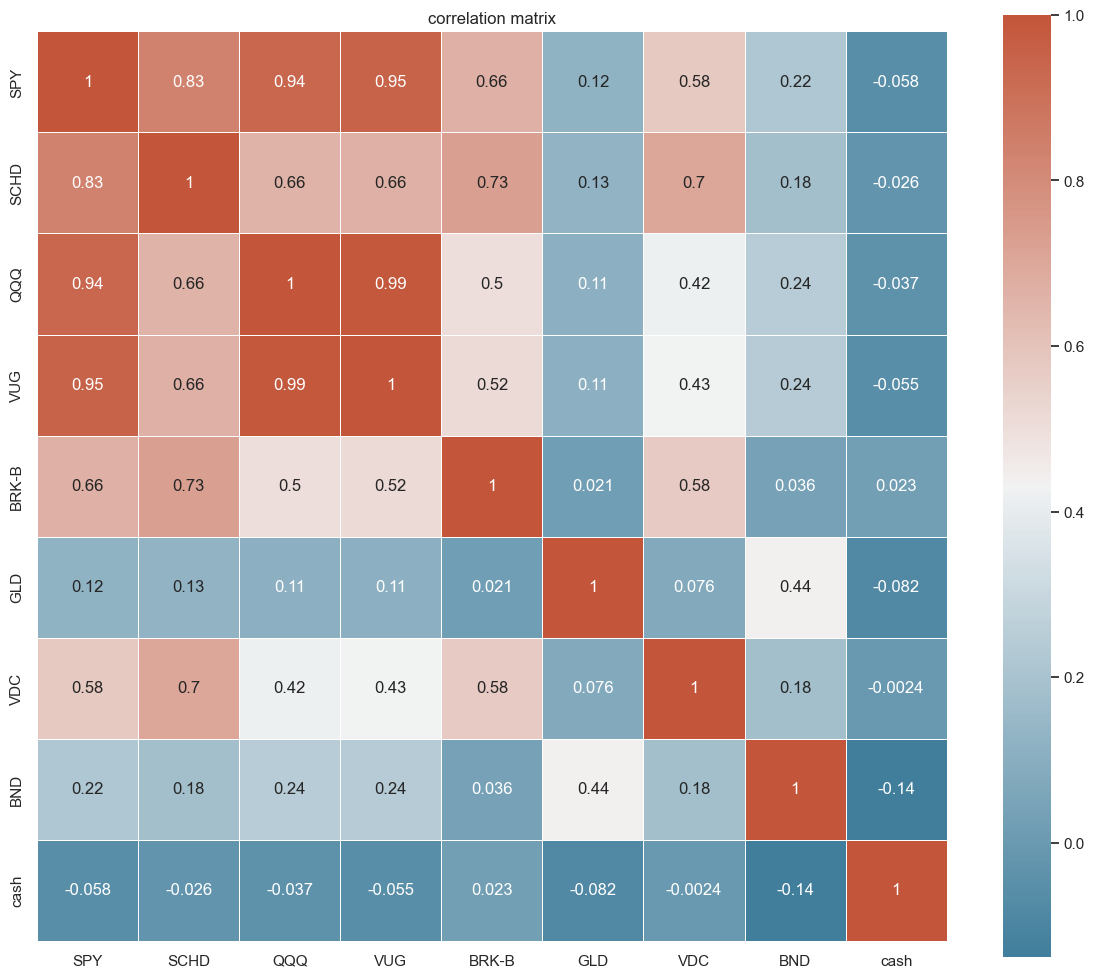

,SPY,SCHD,QQQ,VUG,BRK-B,GLD,VDC,BND,cash
SPY,1.000,0.834,0.937,0.948,0.664,0.122,0.580,0.220,-0.058
SCHD,0.834,1.000,0.661,0.664,0.731,0.127,0.702,0.180,-0.026
QQQ,0.937,0.661,1.000,0.987,0.500,0.108,0.422,0.244,-0.037
VUG,0.948,0.664,0.987,1.000,0.516,0.110,0.430,0.242,-0.055
BRK-B,0.664,0.731,0.500,0.516,1.000,0.021,0.577,0.036,0.023
GLD,0.122,0.127,0.108,0.110,0.021,1.000,0.076,0.435,-0.082
VDC,0.580,0.702,0.422,0.430,0.577,0.076,1.000,0.179,-0.002
BND,0.220,0.180,0.244,0.242,0.036,0.435,0.179,1.000,-0.138
cash,-0.058,-0.026,-0.037,-0.055,0.023,-0.082,-0.002,-0.138,1.000


In [83]:
corr = calc_rolling_corr(log_df)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
_, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr,
    # mask=np.triu(np.ones_like(corr, dtype=bool)),
    square=True,
    # center=0,
    annot=True,
    linewidths=.5,
    cmap=cmap,
    ax=ax
)
ax.set_title('correlation matrix')
plt.tight_layout()
plt.savefig(f"figs/[{START.strftime('%y%m')}-{END.strftime('%y%m')}] corr.png", dpi=160)
plt.show()
corr

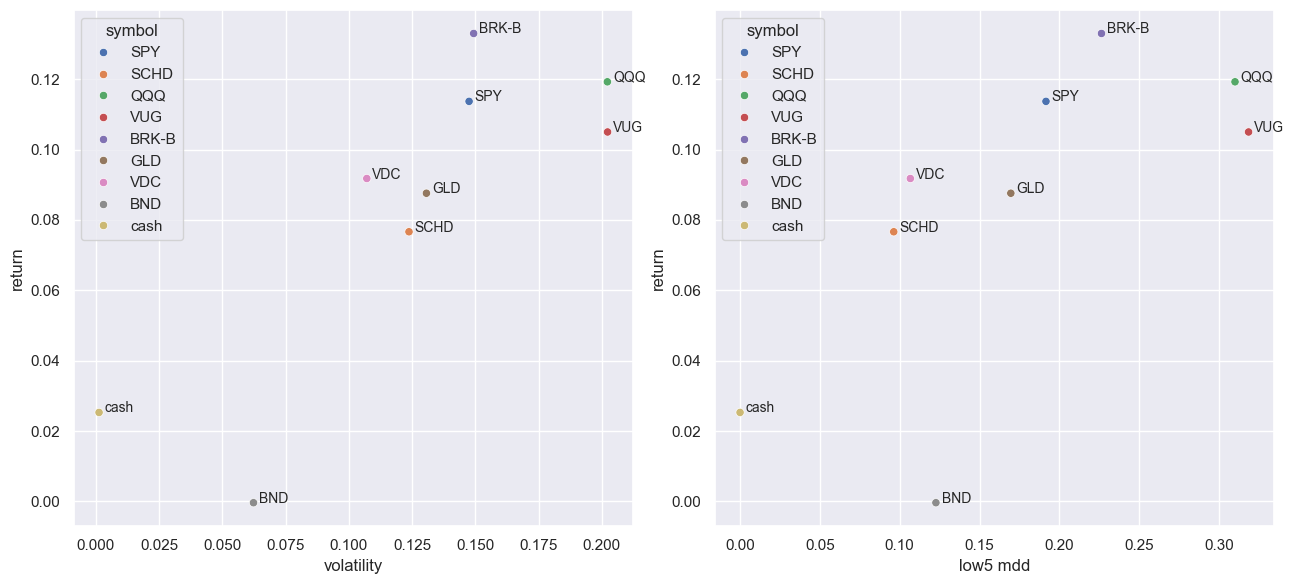

In [84]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
vola_df = plot_riskreturn(df, ax=ax[0], risk_fn=calc_volatility)
mdd_df = plot_riskreturn(df, ax=ax[1], risk_fn=calc_low5_mdd)
plt.tight_layout()

label_point(vola_df, ax[0])
label_point(mdd_df, ax[1])

plt.savefig(f"figs/[{START.strftime('%y%m')}-{END.strftime('%y%m')}] risk_return.png", dpi=160)
plt.show()

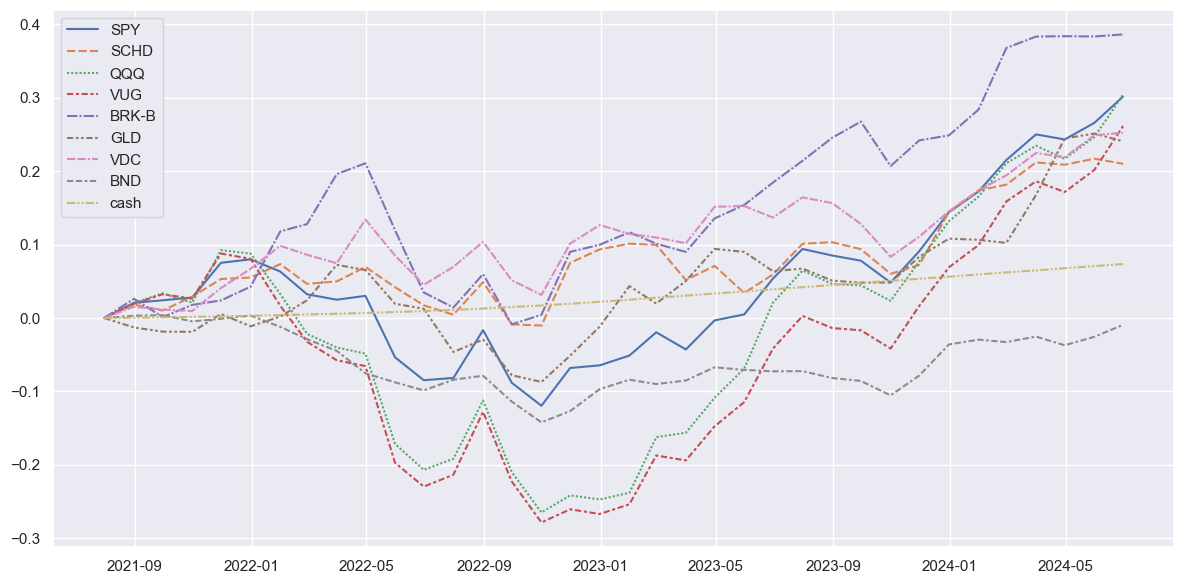

In [85]:
_ = plt.figure(figsize=(12, 6))
sns.lineplot(monthly_df.apply(np.log))
# sns.lineplot(df[targets].apply(np.log))
plt.tight_layout()
plt.savefig(f"figs/[{START.strftime('%y%m')}-{END.strftime('%y%m')}] log_price.png", dpi=160)
plt.show()

In [86]:
@lru_cache
def get_variants(a, b, rebal=True):
    return get_rebal_variants(df, a, b) if rebal else get_blend_variants(df, a, b)

In [87]:
def plot_multi_risk(a, b, figsize=(13, 6), **kwargs):
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, **kwargs)
    plot_riskreturn(get_variants(a, b), ax=ax[0], risk_fn=calc_volatility, labels=(a, b))
    plot_riskreturn(get_variants(a, b), ax=ax[1], risk_fn=calc_low5_mdd, labels=(a, b))
    plt.tight_layout()
    plt.show()

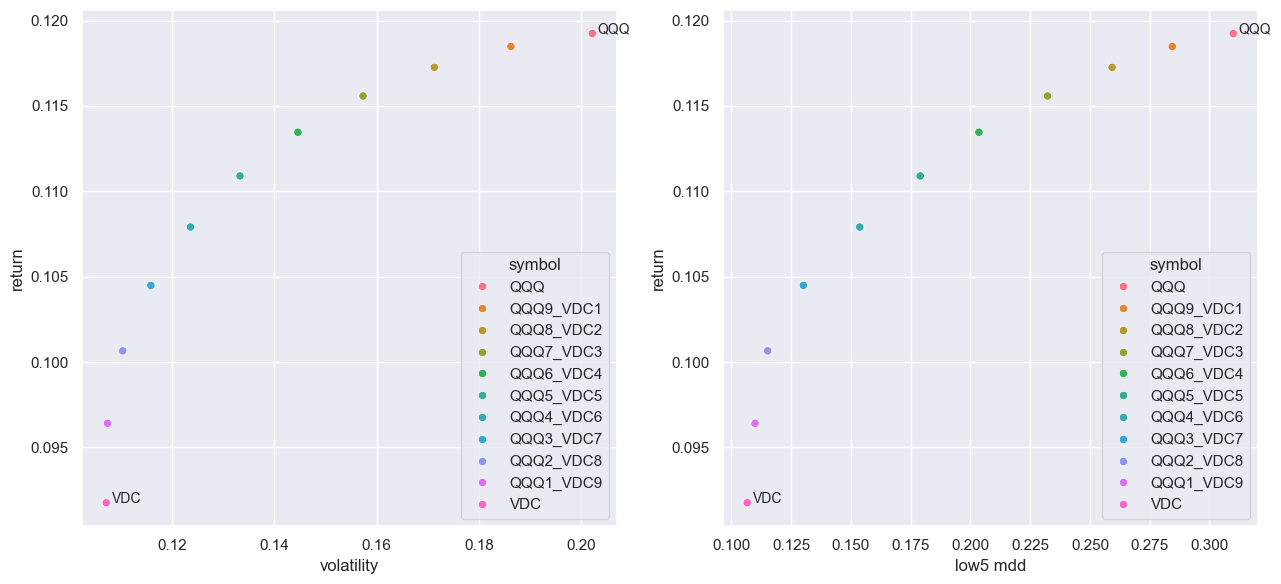

In [88]:
plot_multi_risk('QQQ', 'VDC')

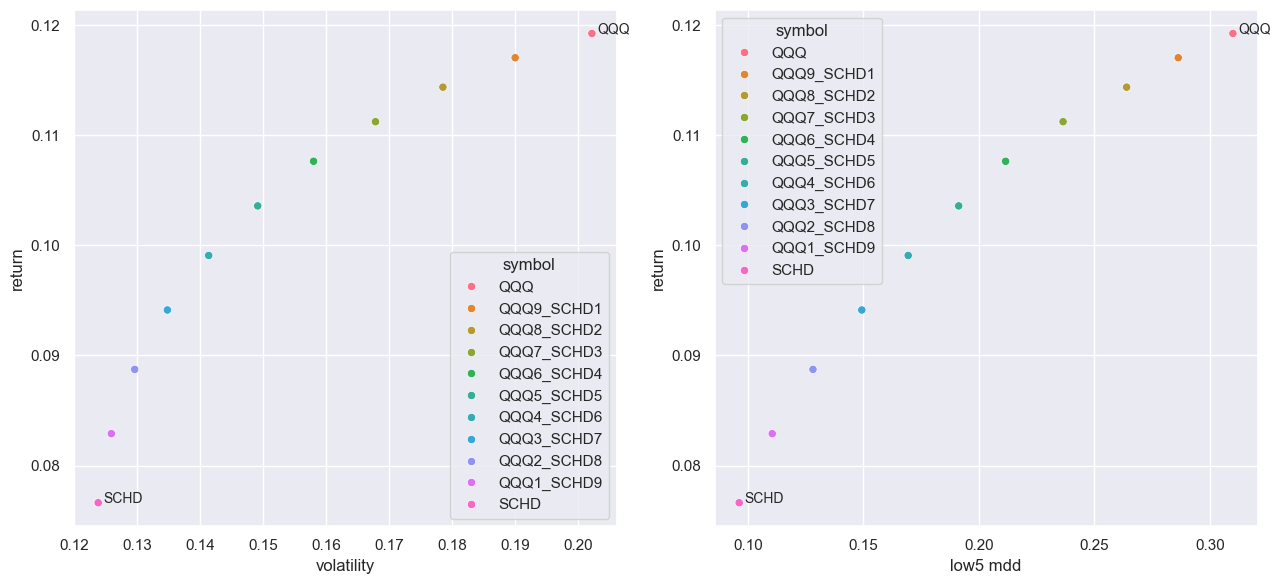

In [89]:
plot_multi_risk('QQQ', 'SCHD')

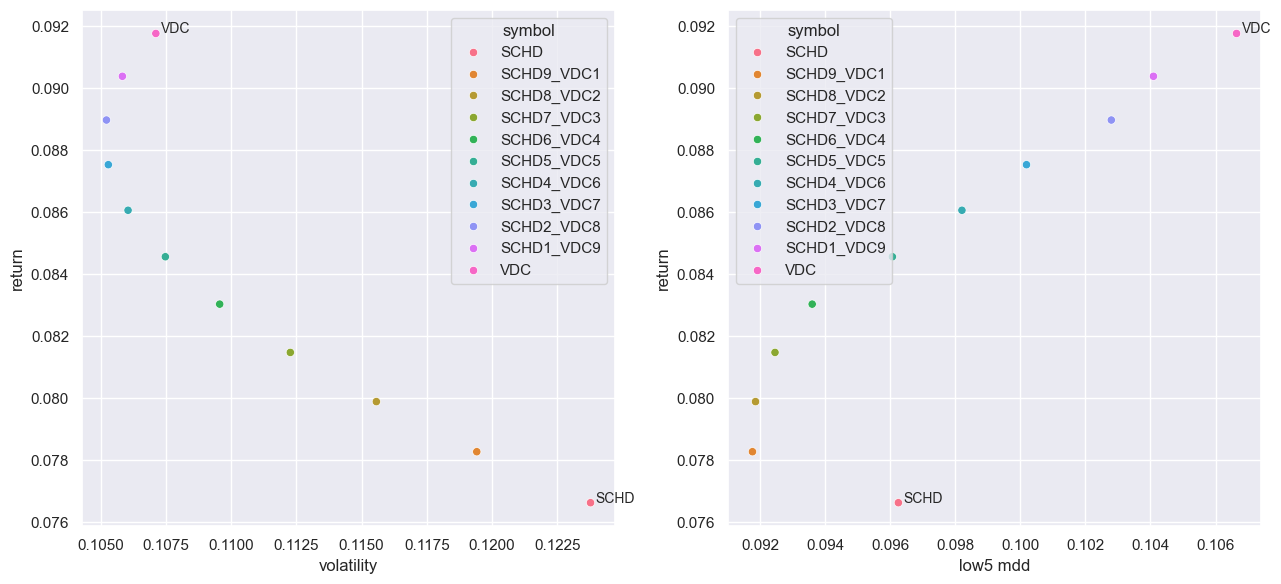

In [90]:
plot_multi_risk('SCHD', 'VDC')

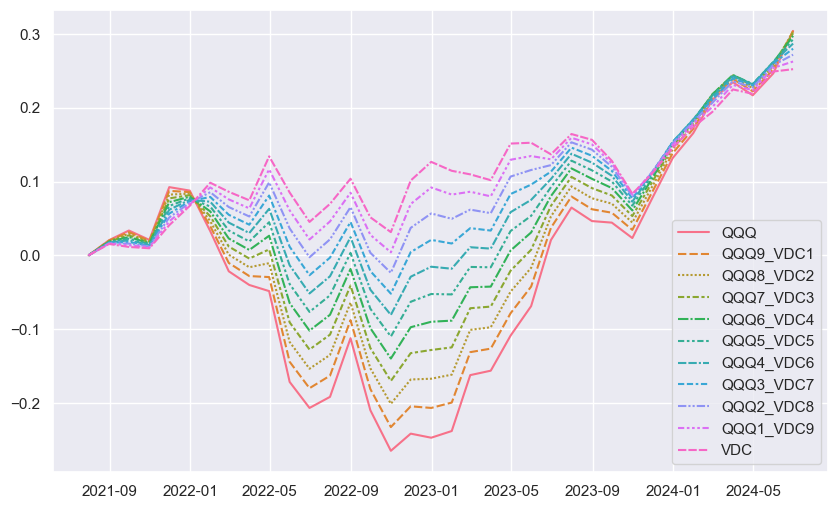

In [91]:
plt.figure(figsize=(10, 6))
sns.lineplot(get_variants('QQQ', 'VDC').resample('ME').mean().apply(np.log))
plt.show()

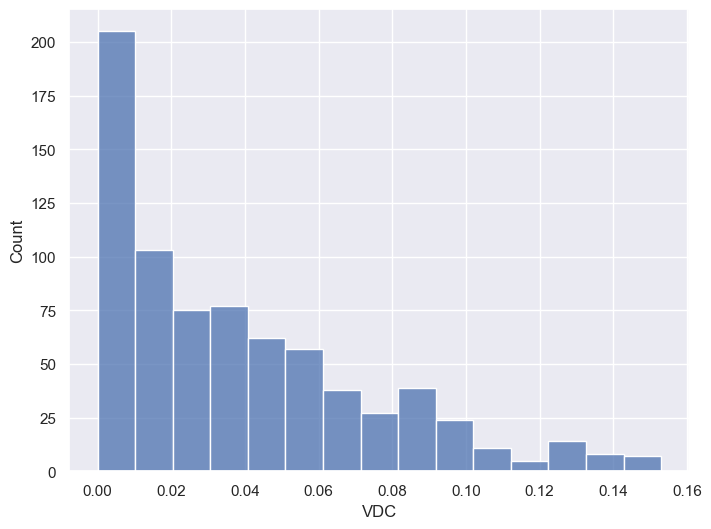

np.float64(0.10664606442319965)

In [92]:
mdd = calc_mdd(df['VDC'])
sns.histplot(mdd)
plt.show()
mdd.quantile(0.95)

In [93]:
@lru_cache(maxsize=500)
def _rebal_cache_internel(w_hashable: Tuple[Tuple[str, float], ...], name):
    _w = {_k: _v for _k, _v in w_hashable}
    return rebalance(df, _w, name)
def rebal_cache(weight, name='rebal'):
    _w = tuple(sorted(weight.items()))
    return _rebal_cache_internel(_w, name)

In [94]:
a, b, c = 'QQQ', 'VDC', 'SCHD'

rebal_all = []
for i in tqdm.tqdm(range(10 + 1)):
    for j in range(10-i + 1):
        k = 10 - (i+j)
        name = f"{i}_{j}_{k}"
        weight = {a: i, b: j, c: k}
        # print(weight)
        rebal_all.append(rebal_cache(weight, name))
rebal_all = pd.concat(rebal_all, axis=1)
rebal_all

  0%|          | 0/11 [00:00<?, ?it/s]

,0_0_10,0_1_9,0_2_8,0_3_7,0_4_6,0_5_5,0_6_4,0_7_3,0_8_2,0_9_1,...,7_0_3,7_1_2,7_2_1,7_3_0,8_0_2,8_1_1,8_2_0,9_0_1,9_1_0,10_0_0
date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,1.005,1.004,1.002,1.001,1.000,0.999,0.997,0.996,0.995,0.994,...,0.993,0.992,0.991,0.989,0.991,0.990,0.989,0.990,0.989,0.988
2021-07-06,1.000,0.999,0.998,0.997,0.996,0.995,0.994,0.993,0.991,0.990,...,0.995,0.994,0.993,0.992,0.995,0.994,0.993,0.994,0.993,0.993
2021-07-07,0.996,0.996,0.995,0.995,0.994,0.994,0.993,0.992,0.992,0.991,...,0.998,0.998,0.997,0.997,0.999,0.998,0.997,0.999,0.998,0.999
2021-07-08,0.990,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,0.989,...,0.989,0.988,0.988,0.988,0.988,0.988,0.988,0.988,0.988,0.988
2021-07-09,1.001,1.000,1.000,0.999,0.998,0.998,0.997,0.996,0.996,0.995,...,0.996,0.996,0.995,0.994,0.995,0.995,0.994,0.995,0.994,0.994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,1.247,1.253,1.258,1.263,1.268,1.273,1.277,1.282,1.287,1.291,...,1.350,1.355,1.359,1.364,1.358,1.363,1.368,1.365,1.370,1.370
2024-06-25,1.246,1.252,1.257,1.262,1.267,1.271,1.276,1.281,1.285,1.289,...,1.352,1.356,1.361,1.366,1.360,1.365,1.370,1.368,1.372,1.373
2024-06-26,1.250,1.255,1.259,1.262,1.266,1.270,1.274,1.277,1.281,1.284,...,1.356,1.360,1.363,1.367,1.365,1.368,1.372,1.372,1.376,1.377


In [95]:
sym_all = ['10_0_0', '0_10_0', '0_0_10']

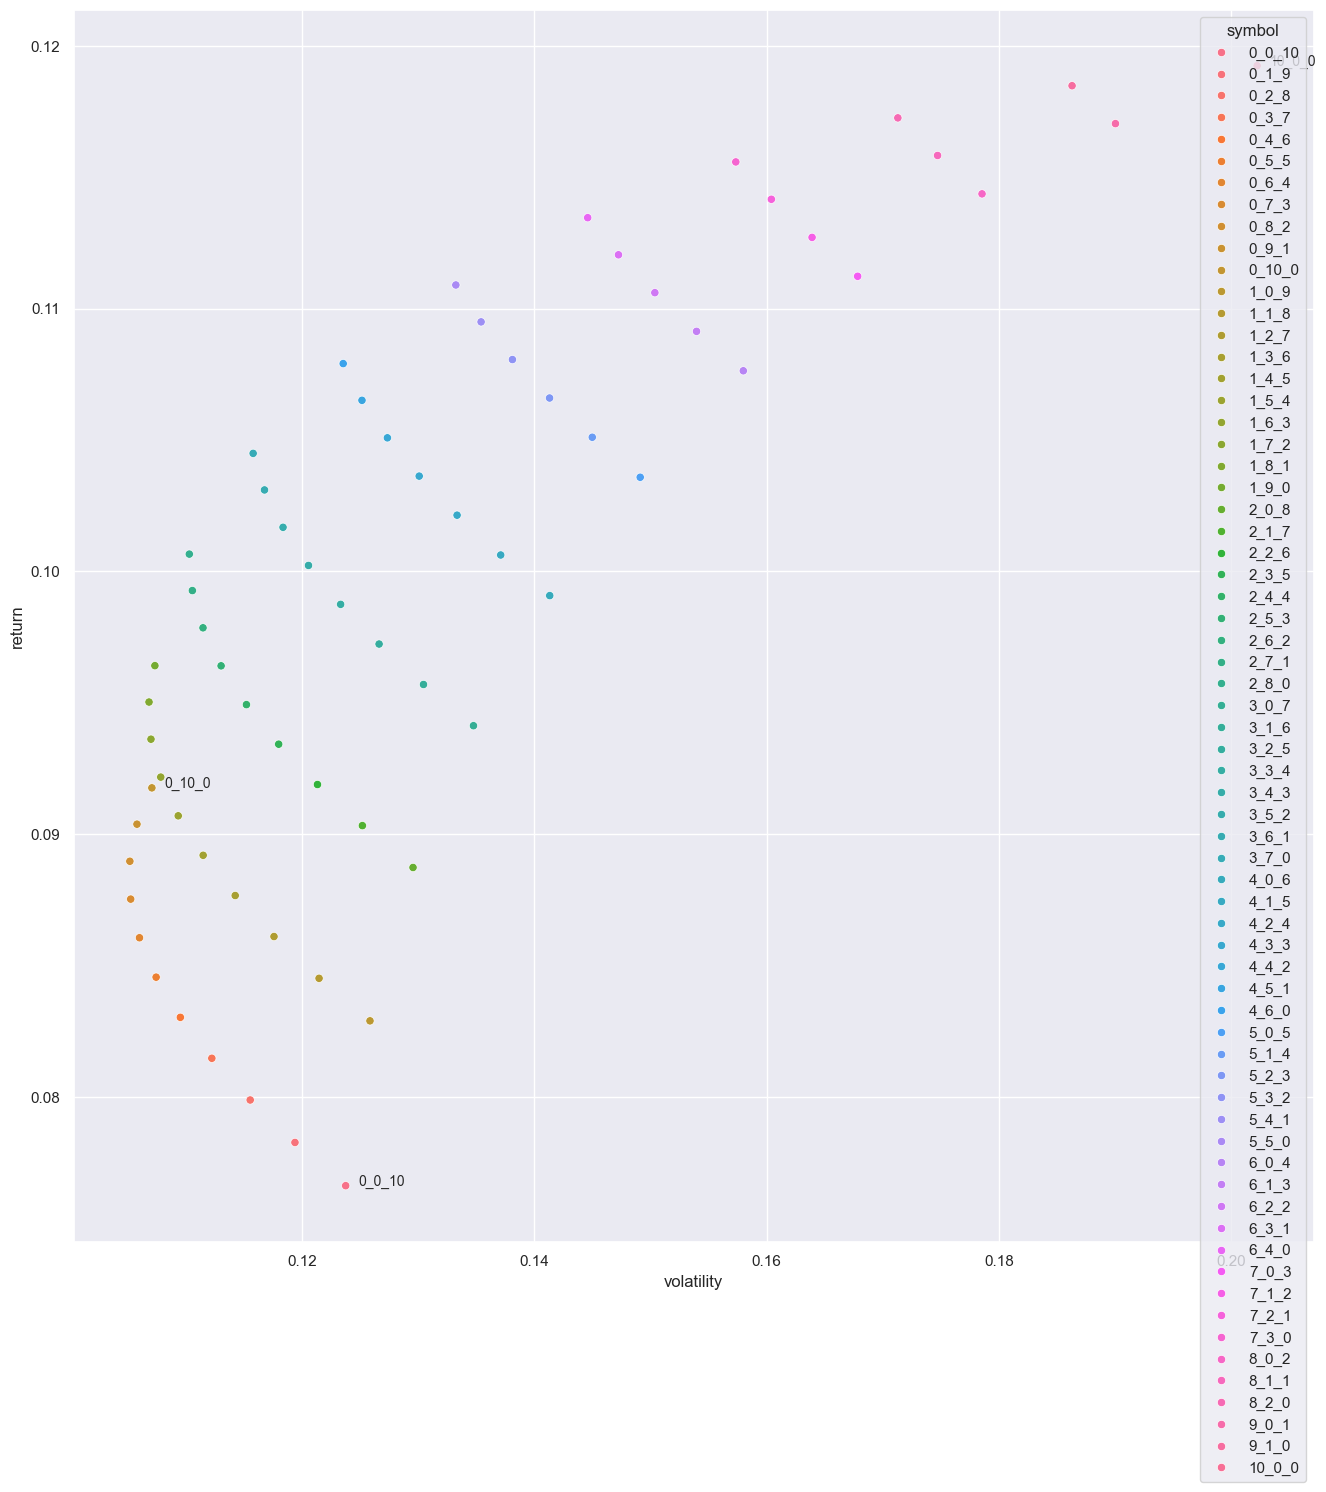

,symbol,risk,return
0,0_0_10,0.124,0.077
1,0_1_9,0.119,0.078
2,0_2_8,0.116,0.080
3,0_3_7,0.112,0.081
4,0_4_6,0.110,0.083
...,...,...,...
61,8_1_1,0.175,0.116
62,8_2_0,0.171,0.117
63,9_0_1,0.190,0.117
64,9_1_0,0.186,0.118


In [102]:
fig = plt.figure(figsize=(16, 16))
# rr = plot_riskreturn(rebal_all)
rr = plot_riskreturn(rebal_all, risk_fn=calc_volatility, labels=sym_all)
fig.tight_layout()
fig.savefig(f"figs/[{START.strftime('%y%m')}-{END.strftime('%y%m')}] {a}_{b}_{c}_volatility.png", dpi=120)
rr

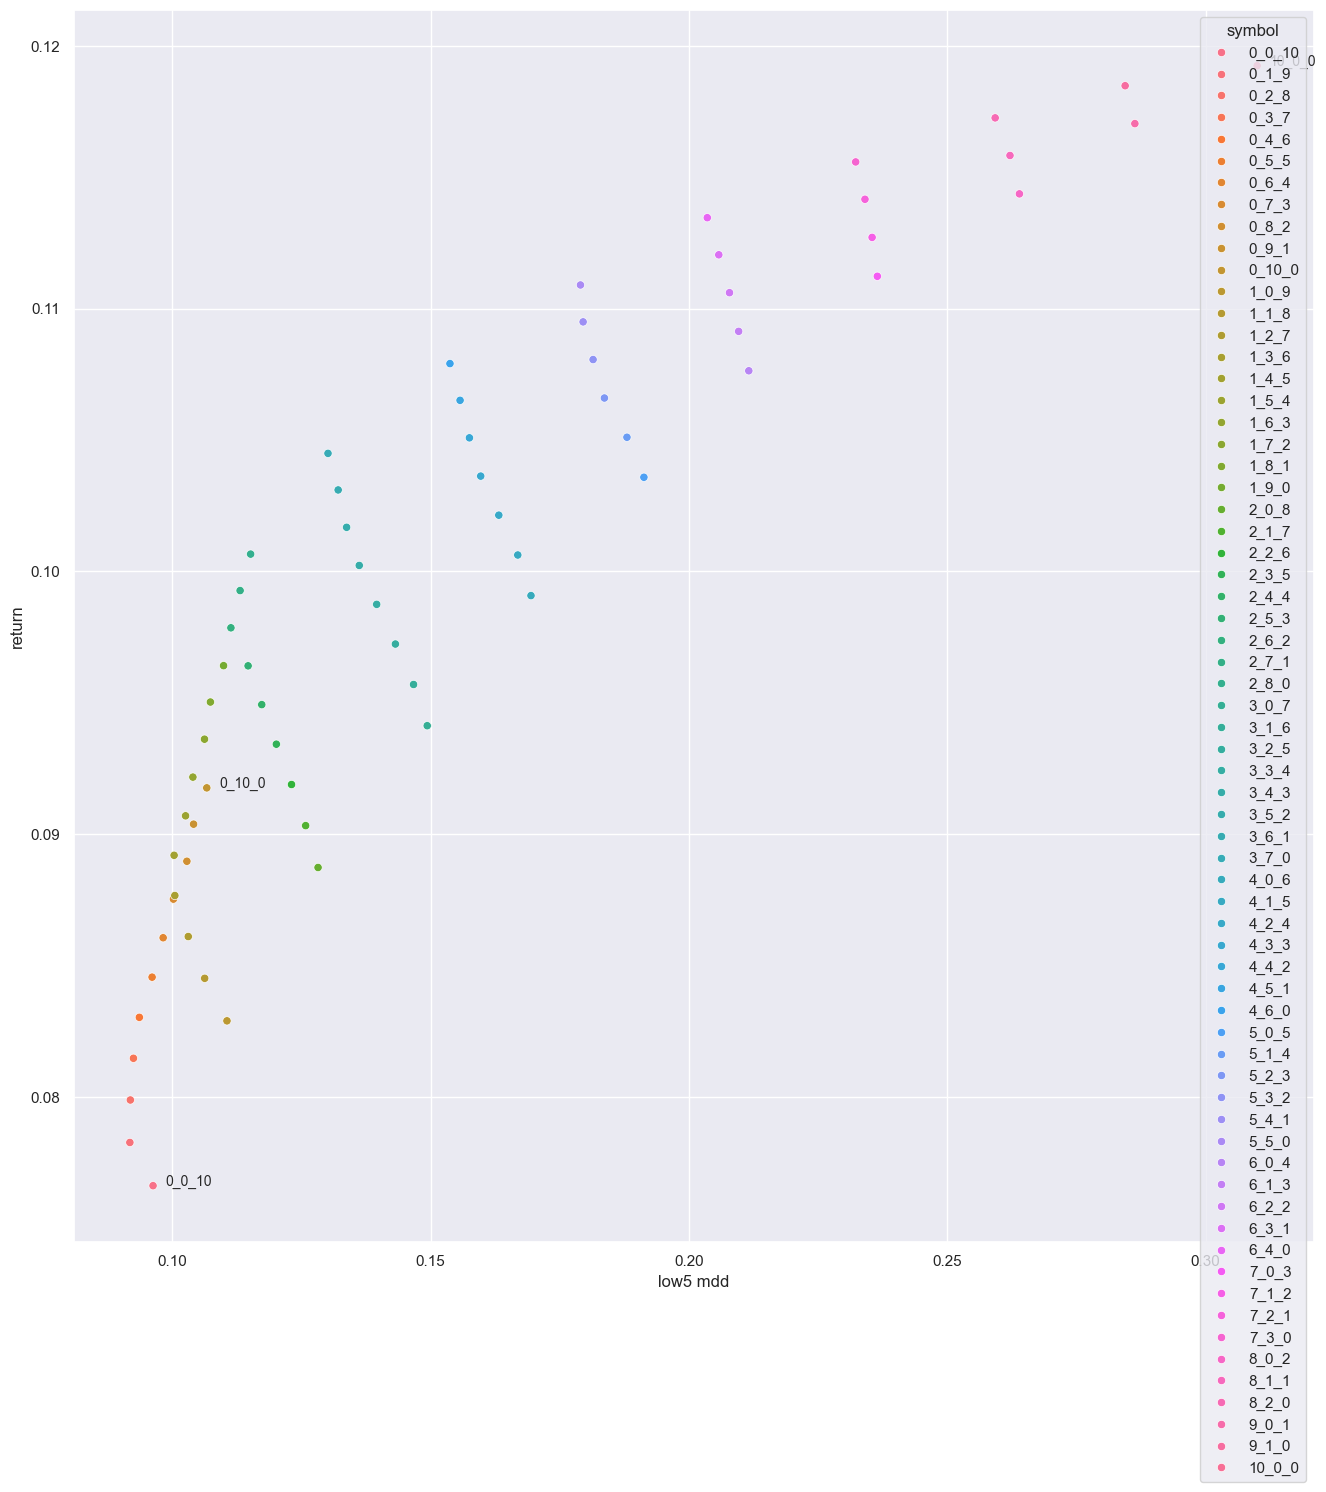

,symbol,risk,return
0,0_0_10,0.096,0.077
1,0_1_9,0.092,0.078
2,0_2_8,0.092,0.080
3,0_3_7,0.092,0.081
4,0_4_6,0.094,0.083
...,...,...,...
61,8_1_1,0.262,0.116
62,8_2_0,0.259,0.117
63,9_0_1,0.286,0.117
64,9_1_0,0.284,0.118


In [103]:
fig = plt.figure(figsize=(16, 16))
# rr = plot_riskreturn(rebal_all)
rr = plot_riskreturn(rebal_all, risk_fn=calc_low5_mdd, labels=sym_all)
fig.tight_layout()
fig.savefig(f"figs/[{START.strftime('%y%m')}-{END.strftime('%y%m')}] {a}_{b}_{c}_mdd.png", dpi=120)
rr

In [98]:
risk_slope = 0.9   # higher value to low risk
r_sort = rr.copy()
r_sort['key'] = r_sort['return'] - r_sort['risk'] / risk_slope
r_sort.sort_values('key', inplace=True, ascending=False)
r_sort

,symbol,risk,return,key
4,0_4_6,0.094,0.083,-0.021
3,0_3_7,0.092,0.081,-0.021
2,0_2_8,0.092,0.080,-0.022
5,0_5_5,0.096,0.085,-0.022
15,1_4_5,0.100,0.089,-0.022
...,...,...,...,...
61,8_1_1,0.262,0.116,-0.175
60,8_0_2,0.264,0.114,-0.179
64,9_1_0,0.284,0.118,-0.198
63,9_0_1,0.286,0.117,-0.201


In [35]:
rr[rr['risk'] < 0.105]

,symbol,risk,return
0,0_0_10,0.095,0.146
1,0_1_9,0.092,0.145
2,0_2_8,0.091,0.144
3,0_3_7,0.089,0.142
4,0_4_6,0.090,0.141
5,0_5_5,0.090,0.140
6,0_6_4,0.090,0.139
7,0_7_3,0.091,0.138
8,0_8_2,0.092,0.136
9,0_9_1,0.092,0.135
